<a href="https://colab.research.google.com/github/TESNIERES/python-for-data-analysis/blob/master/pythonfordataanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dataset

In [140]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import des Modules

In [0]:
import pandas as pd
import numpy as np
import datetime as dt
from random import randint
import math
import re
import scipy
import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt
import matplotlib
from sklearn import preprocessing
from datetime import datetime
import io
import seaborn as sns 

# Pré-Processing

In [142]:
df_incident_log_event = pd.read_csv("drive/My Drive/Projet Python for data analysis/incident_event_log.csv", sep=",",index_col=0, parse_dates=True, encoding="utf8", decimal=",")
df_incident_log_event.describe() 
df_incident_log_event.head()

,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 21,29/2/2016 01:23,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,Created by 171,29/2/2016 04:57,Updated by 746,29/2/2016 04:57,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [0]:
def time_to_complete(dataframe):   
    test = dataframe.copy(deep=False)
    test = test[test['resolved_at'] != '?']
    test.resolved_at = pd.to_datetime(test['resolved_at'], format='%d/%m/%Y %H:%M')
    test.opened_at = pd.to_datetime(test['opened_at'], format='%d/%m/%Y %H:%M')
    test.time_to_complete = test.resolved_at - test.opened_at
    test['time_to_complete'] = (test.time_to_complete).dt.total_seconds()
    return test

In [144]:
test = time_to_complete(df_incident_log_event)
test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,time_to_complete
number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 21,29/2/2016 01:23,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,5/3/2016 12:00,36780.0
INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,5/3/2016 12:00,36780.0
INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,5/3/2016 12:00,36780.0
INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,5/3/2016 12:00,36780.0
INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,Created by 171,29/2/2016 04:57,Updated by 746,29/2/2016 04:57,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,2016-03-01 09:52:00,6/3/2016 10:00,105120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INC0120835,Closed,False,1,0,4,True,Caller 116,Opened by 12,2017-02-16 09:09:00,?,?,Updated by 27,16/2/2017 09:53,Email,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3 - Moderate,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 9,Resolved by 9,2017-02-16 09:53:00,16/2/2017 09:53,2640.0
INC0121064,Active,True,0,0,0,True,Caller 116,Opened by 12,2017-02-16 14:17:00,?,?,Updated by 908,16/2/2017 14:17,Email,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 10,False,False,Do Not Notify,?,?,?,?,code 6,Resolved by 9,2017-02-16 16:38:00,16/2/2017 16:38,8460.0
INC0121064,Active,True,1,0,1,True,Caller 116,Opened by 12,2017-02-16 14:17:00,?,?,Updated by 60,16/2/2017 15:20,Email,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3 - Moderate,Group 31,?,False,False,Do Not Notify,?,?,?,?,code 6,Resolved by 9,2017-02-16 16:38:00,16/2/2017 16:38,8460.0


## On transforme maintenant les priority en int

In [0]:
test['priority'] = test['priority'].astype('category')
test['priority'] = test['priority'].cat.reorder_categories(['1 - Critical', '2 - High', '3 - Moderate', '4 - Low'], ordered=False)
test['priority'] = test['priority'].cat.codes

In [0]:
dict = {
    'Do Not Notify': 0,
    'Send Email': 1
}
test['notify'] = test['notify'].map(dict)

In [147]:
test.isna().sum()

incident_state             0
active                     0
reassignment_count         0
reopen_count               0
sys_mod_count              0
made_sla                   0
caller_id                  0
opened_by                  0
opened_at                  0
sys_created_by             0
sys_created_at             0
sys_updated_by             0
sys_updated_at             0
contact_type               0
location                   0
category                   0
subcategory                0
u_symptom                  0
cmdb_ci                    0
impact                     0
urgency                    0
priority                   0
assignment_group           0
assigned_to                0
knowledge                  0
u_priority_confirmation    0
notify                     0
problem_id                 0
rfc                        0
vendor                     0
caused_by                  0
closed_code                0
resolved_by                0
resolved_at                0
closed_at     

 ## On verifie les Na par rapport à la taille du dataset pour nettoyer.

In [148]:
test.shape

(138571, 36)

In [0]:
test = test.replace("?", np.nan)

In [150]:
test.isna().sum(axis = 0)

incident_state                  0
active                          0
reassignment_count              0
reopen_count                    0
sys_mod_count                   0
made_sla                        0
caller_id                      29
opened_by                    4714
opened_at                       0
sys_created_by              49943
sys_created_at              49943
sys_updated_by                  0
sys_updated_at                  0
contact_type                    0
location                       73
category                       78
subcategory                   108
u_symptom                   32155
cmdb_ci                    138128
impact                          0
urgency                         0
priority                        0
assignment_group            14204
assigned_to                 27346
knowledge                       0
u_priority_confirmation         0
notify                          0
problem_id                 136276
rfc                        137580
vendor        

On supprime les colonnes suivantes:

On drop:
- cmdb_ci -> 138128/138571 valeurs NAn
- problem_id -> 136276/138571 valeurs NAn
- rfc -> 137580/138571 valeurs NAn
- vendor -> 138327/138571 valeurs NAn
- caused_by -> 138548/138571 valeurs NAn

Puis on supprime les dates

In [0]:
test = test.drop(['cmdb_ci', 'problem_id', 'rfc', 'vendor', 'caused_by'], axis=1)
test = test.drop(['closed_at', 'resolved_at', 'opened_at', 'sys_created_at', 'sys_updated_at'], axis=1)

##Corrélation entre les variables

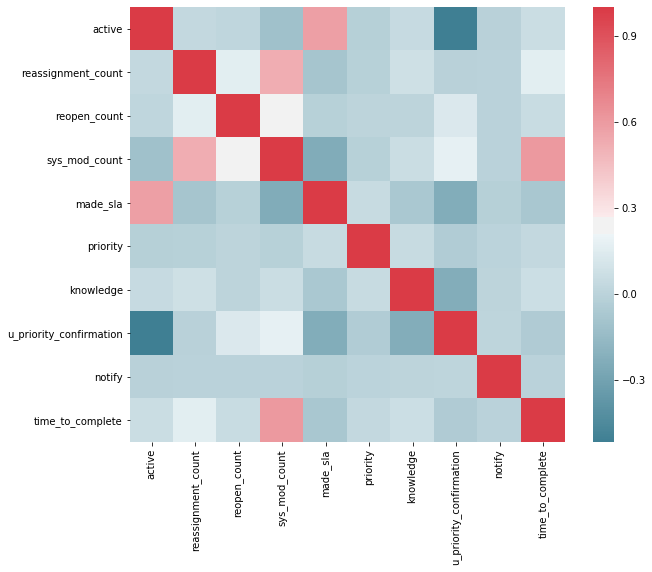

In [152]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
corr = test.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Conclusion : On constate que time_to_resolve est hautement corrélé avec la variable sys_mod_count qui est elle meme corrélée avec reassignment_count, cependant on ne voit que les variables qui ne sont pas des Objets, il faut donc transformer les objets.

# Visualisation de données pertinentes

In [153]:
test.head()

,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,sys_created_by,sys_updated_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,time_to_complete
number,,,,,,,,,,,,,,,,,,,,,,,,,,
INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,Created by 6,Updated by 21,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,2,Group 56,NaN,True,False,0,code 5,Resolved by 149,36780.0
INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,Created by 6,Updated by 642,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,2,Group 56,NaN,True,False,0,code 5,Resolved by 149,36780.0
INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,Created by 6,Updated by 804,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,2,Group 56,NaN,True,False,0,code 5,Resolved by 149,36780.0
INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,Created by 6,Updated by 908,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,2,Group 56,NaN,True,False,0,code 5,Resolved by 149,36780.0
INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,Created by 171,Updated by 746,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,2 - Medium,2 - Medium,2,Group 70,Resolver 89,True,False,0,code 5,Resolved by 81,105120.0


In [154]:
test.dtypes 

incident_state              object
active                        bool
reassignment_count           int64
reopen_count                 int64
sys_mod_count                int64
made_sla                      bool
caller_id                   object
opened_by                   object
sys_created_by              object
sys_updated_by              object
contact_type                object
location                    object
category                    object
subcategory                 object
u_symptom                   object
impact                      object
urgency                     object
priority                     int64
assignment_group            object
assigned_to                 object
knowledge                     bool
u_priority_confirmation       bool
notify                       int64
closed_code                 object
resolved_by                 object
time_to_complete           float64
dtype: object

## Encodage et normalisation

On encode toutes les données dont la colonne est un objet, ceci va nous permettre de savoir si l'on doit classifier la donnée après avoir effectué nos regressions car il est possible ces colonnes classées en catégorie aient avoir un impacte sur le temps d'execution d'un ticket.

In [0]:
from sklearn import preprocessing

for column in test.select_dtypes(include=['object']):

  test[column], _ = pd.factorize(test[column])
  x = test[[column]].values.astype(float)
# create a minimum and maximum processor object
  min_max_scaler = preprocessing.MinMaxScaler()
# Create an object to transform the data to fit minmax processor
  x_scaled = min_max_scaler.fit_transform(x)
 # Run the normalizer on the dataframe
  test[column]=x_scaled


##Corrélation
Règle de corrélation :

- de 0.0 à 0.2 Corrélation très faible à négigeable
- entre 0.2 et 0.4 Corrélation faible, peu élevée (pas très importante)
- entre 0.4 et 0.7 Corrélation modérée
- entre 0.7 et 0.9 Corrélation forte, élevée
- entre 0.9 et 1.0 Corrélation très forte

In [156]:
test.corr()


,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,sys_created_by,sys_updated_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,time_to_complete
incident_state,1.000000,-0.056281,0.175692,0.067503,0.257256,-0.034371,-0.039728,0.003475,0.049914,0.016525,0.002955,-0.012534,0.000238,0.029035,-0.004324,0.000583,-0.006173,0.026969,-0.006243,0.020226,0.058758,-0.113769,-0.015778,-0.012442,-0.053583,0.152654
active,-0.056281,1.000000,0.032315,0.017591,-0.110058,0.580637,-0.024435,-0.002255,0.038986,0.272679,-0.000953,-0.018431,-0.004153,0.017228,-0.011471,0.005794,0.013885,-0.019737,0.012892,-0.112124,0.040452,-0.517575,-0.010438,0.012110,-0.025339,0.062906
reassignment_count,0.175692,0.032315,1.000000,0.159565,0.523904,-0.089874,-0.053545,-0.017898,0.039281,0.067817,-0.014795,-0.002487,0.024251,0.038158,-0.011798,0.007759,0.011978,-0.018430,0.008838,-0.081199,0.080353,-0.009653,-0.006400,0.033260,-0.048532,0.158766
reopen_count,0.067503,0.017591,0.159565,1.000000,0.247028,-0.016026,0.022703,-0.000320,-0.004370,0.165229,-0.005779,-0.011356,0.014784,0.024102,-0.003630,-0.014310,-0.017927,0.004485,-0.008979,-0.009838,0.006366,0.130322,-0.003132,0.022121,-0.001981,0.052963
sys_mod_count,0.257256,-0.110058,0.523904,0.247028,1.000000,-0.244711,-0.059593,0.007979,0.078293,0.063844,0.008264,-0.026226,0.074365,0.067366,0.009125,0.022589,0.026604,-0.017010,0.125825,0.031419,0.062451,0.178844,-0.006558,0.022933,0.007964,0.604187
made_sla,-0.034371,0.580637,-0.089874,-0.016026,-0.244711,1.000000,0.051601,0.005808,-0.026778,0.154697,-0.005245,0.007470,-0.014647,-0.008367,0.023191,0.005934,-0.032563,0.049681,-0.042763,-0.048568,-0.070345,-0.235154,-0.025199,-0.001971,-0.001442,-0.073415
caller_id,-0.039728,-0.024435,-0.053545,0.022703,-0.059593,0.051601,1.000000,0.121789,-0.024062,0.045627,0.041567,0.042300,0.026702,0.028029,0.096578,-0.042081,-0.050204,-0.006512,-0.083666,0.050029,-0.339834,0.121122,-0.021909,0.051508,0.071008,-0.084221
opened_by,0.003475,-0.002255,-0.017898,-0.000320,0.007979,0.005808,0.121789,1.000000,0.593156,0.205380,0.203016,-0.003497,0.094730,0.094809,0.099185,-0.074135,-0.009823,-0.074667,0.019441,0.116526,-0.227764,0.063209,0.032929,0.025876,0.193166,0.006802
sys_created_by,0.049914,0.038986,0.039281,-0.004370,0.078293,-0.026778,-0.024062,0.593156,1.000000,0.176707,0.142134,-0.003750,0.072522,0.109638,0.027219,-0.038804,0.004228,-0.043096,0.141170,0.149974,-0.088570,-0.046638,-0.002508,-0.049864,0.043997,0.083653
sys_updated_by,0.016525,0.272679,0.067817,0.165229,0.063844,0.154697,0.045627,0.205380,0.176707,1.000000,0.197349,0.003024,0.091051,0.079149,0.034599,0.001878,0.036649,-0.061017,0.086461,0.239205,-0.065725,-0.045435,-0.003658,0.022383,0.262430,0.058117


##Conclusion

On constate qu'il y a deux variables corrélée avec notre variable à prédire (time_to_complete) : 

- sys_mod_count -> corr = 0.6
- assignment_group -> corr = 0.21

d'après notre règle de corrélation on ne garde que sys_mod_count et reassignement_count car on rappelle que c'est une variable corrélée avec sys_mod_count

Plus le sys_mod_count augmente plus le time_to_complete augmente.

In [157]:
test.astype(str).groupby('number').agg(lambda x: ','.join(x.unique()))

,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,sys_created_by,sys_updated_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,time_to_complete
number,,,,,,,,,,,,,,,,,,,,,,,,,,
INC0000045,"0.0,0.125,0.25","True,False",0,0,"0,2,3,4",True,0.00019650225977598743,0.0048543689320388345,0.005405405405405406,"0.0,0.0011918951132300357,0.002383790226460071...",0.0,0.004545454545454545,0.017543859649122806,0.003937007874015748,0.0019083969465648854,0.0,0.0,2,0.01282051282051282,0.0,True,False,0,0.058823529411764705,0.004629629629629629,36780.0
INC0000047,"0.0,0.375,0.5,0.125,0.25","True,False","0,1",0,"0,1,2,3,4,5,6,7,8",True,0.00019650225977598743,0.009708737864077669,0.010810810810810811,"0.004767580452920143,0.0,0.0023837902264600714...",0.0,0.00909090909090909,0.03508771929824561,0.007874015748031496,0.003816793893129771,0.0,0.0,2,"0.02564102564102564,0.038461538461538464","0.004273504273504274,0.008547008547008548",True,False,0,0.058823529411764705,0.009259259259259259,105120.0
INC0000057,"0.0,0.125,0.25","True,False",0,0,"0,1,2,3,4,5,6",True,0.00039300451955197487,0.0048543689320388345,0.0,"0.0,0.00834326579261025,0.003575685339690107",0.0,0.013636363636363636,0.05263157894736842,0.011811023622047244,0.003816793893129771,0.0,0.0,2,0.02564102564102564,"0.0,0.012820512820512822",True,False,0,0.11764705882352941,0.013888888888888888,74700.0
INC0000060,"0.0,0.375,0.125,0.25","True,False",0,0,"0,1,2,3",True,0.0005895067793279622,0.014563106796116504,0.016216216216216217,"0.009535160905840286,0.01072705601907032,0.003...",0.0,0.013636363636363636,0.07017543859649122,0.015748031496062992,0.0057251908396946565,0.0,0.0,2,0.05128205128205128,0.017094017094017096,True,False,0,0.1764705882352941,0.018518518518518517,192480.0
INC0000062,"0.0,0.125,0.25","True,False","0,1",0,"0,1,2,3,4,5,6,7","True,False",0.0007860090391039497,0.014563106796116504,0.016216216216216217,"0.009535160905840286,0.0023837902264600714,0.0...",0.0,0.01818181818181818,0.08771929824561403,0.01968503937007874,0.007633587786259542,"0.0,0.5",0.0,"2,1","0.02564102564102564,0.0641025641025641",0.0,True,False,0,0.23529411764705882,0.023148148148148147,31980.000000000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INC0118999,"0.375,0.125,0.25","True,False",0,0,"0,5,6",True,0.7626252701906072,0.7766990291262135,0.0,"0.003575685339690107,0.9940405244338498",0.3333333333333333,0.004545454545454545,0.6491228070175439,0.5196850393700787,0.9999999999999999,0.0,0.0,2,0.4615384615384615,0.9957264957264959,False,"False,True",0,0.29411764705882354,0.9953703703703703,2400.0
INC0119390,"0.0,0.375,0.125,0.25","True,False","0,1,2,3",0,"0,1,2,3,4,5,6",True,1.0,0.9999999999999999,0.0,"0.003575685339690107,0.42789034564958284,0.195...",0.6666666666666666,0.9727272727272727,"0.0,0.12280701754385964","0.0,0.19291338582677164",0.0,0.0,0.0,2,"0.02564102564102564,0.4358974358974359,0.75641...","0.0,0.576923076923077,0.6794871794871795",False,"False,True",0,0.29411764705882354,0.2175925925925926,83040.0
INC0120304,"0.375,0.125,0.25","True,False",0,0,"0,1,2",True,0.21831401061112204,0.0048543689320388345,0.0,"0.003575685339690107,0.0",0.3333333333333333,0.7136363636363636,0.9122807017543859,0.47244094488188976,0.1297709923664122,0.0,0.0,2,0.6666666666666666,0.012820512820512822,False,"False,True",0,0.29411764705882354,0.013888888888888888,168300.0


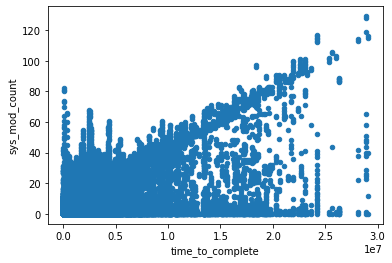

In [158]:
test.plot(x ='time_to_complete', y='sys_mod_count', kind = 'scatter')

# Modèles

## train test

In [0]:
df = test.copy()
X = df.drop('time_to_complete', axis=1)
y = df['time_to_complete']


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

##Tree Decision Regressor

In [161]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0, max_depth=6)
regressor.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [162]:
y_pred = regressor.predict(X_test)
y_pred

array([ 76948.95746297, 446962.34762314, 488794.31831147, ...,
        76948.95746297, 806362.79231808,  76948.95746297])

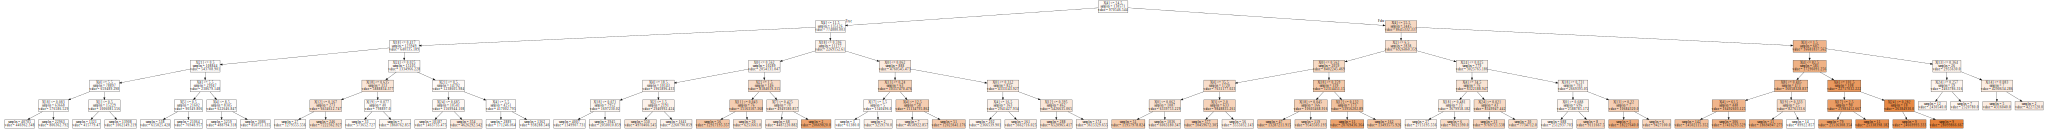

In [163]:
from sklearn.tree import export_graphviz
export_graphviz(regressor, out_file="tree.dot", impurity=False, filled=True)

import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Score

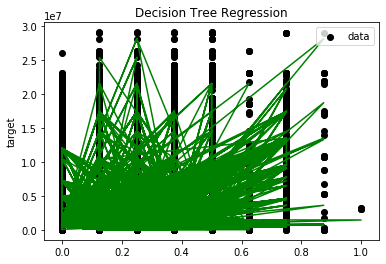

In [164]:
plt.figure()
plt.scatter(X.iloc[:,0], y, c="k", label="data")
plt.plot(X_test.iloc[:,0], y_pred, c="g", linestyle='-')
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

##Regression Linéaire

In [165]:

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.4648961319328099

In [0]:
ypred = reg.predict(X_test)

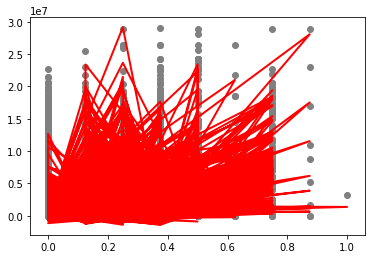

In [171]:
plt.scatter(X_test.iloc[:,0], y_test,  color='gray')
plt.plot(X_test.iloc[:,0], ypred, color='red', linewidth=2)
plt.show()